### Identification of colorectal tumours
with >90% accuracy using a convolutional neural network trained on images of histological samples from the Institute of Pathology, University Medical Center Mannheim, Heidelberg University, Mannheim, Germany.

Each example is a 150 x 150 x 3 RGB digitized image from 20x magnification falling into 1 of 8 categories of cell type.

For more information regarding this dataset see https://zenodo.org/record/53169#.XGZemKwzbmG

In [1]:
import os
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Download and unzip the dataset

The dataset is already included in this project folder however please uncomment and re-run the below cells if you need to repeat the procedure.

In [20]:
# import wget
# url = "https://zenodo.org/record/53169/files/Kather_texture_2016_image_tiles_5000.zip?download=1"
# wget.download(url)

In [ ]:
# local_zip = "./Kather_texture_2016_image_tiles_5000.zip"
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall()

# zip_ref.close()

### Explore images

In [2]:
base_dir = "./Kather_texture_2016_image_tiles_5000"
for dir in os.listdir(base_dir):
    print(f"there are {len(os.listdir(os.path.join(base_dir,dir)))} images in {dir}")

there are 625 images in 01_TUMOR
there are 625 images in 02_STROMA
there are 625 images in 03_COMPLEX
there are 625 images in 04_LYMPHO
there are 625 images in 05_DEBRIS
there are 625 images in 06_MUCOSA
there are 625 images in 07_ADIPOSE
there are 625 images in 08_EMPTY


Printing random sample images
Each image has shape: (150, 150, 3)


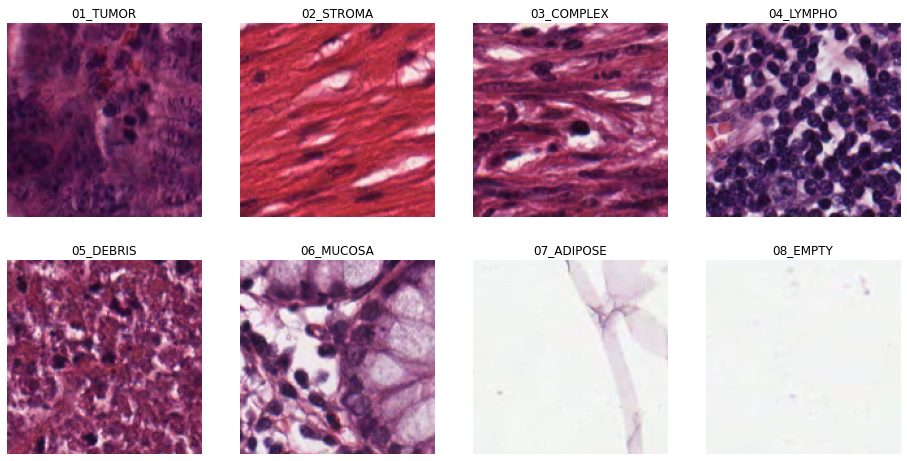

In [3]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print("Printing random sample images")

nrows = 2
ncols = 4
index = np.random.randint(0,625)

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for i, img_path in enumerate(os.listdir(base_dir)):
    img_dir = os.path.join(base_dir, img_path)
    sample_image = load_img(f"{os.path.join(img_dir, os.listdir(img_dir)[index])}")
    if i == 0:
        # Convert an image into its numpy array representation
        sample_array = img_to_array(sample_image)
        print(f"Each image has shape: {sample_array.shape}")
    
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.title.set_text(img_path)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    plt.imshow(sample_image)

### Split images for validation
This function will create a new folder with 500 random images per class for training and another with 125 images per class for validating the model.

In [34]:
import splitfolders
splitfolders.ratio(base_dir, output="histological_images", seed=1337, ratio=(.8, 0.2,0)) 

Copying files: 5000 files [00:08, 620.19 files/s]


In [6]:
train_dir = r"histological_images/train"
validation_dir = r"histological_images/val"

### Data preprocessing 
#### Training and validation image data generators
Now that the data are split into training and validation sets I will create generators to feed the labelled images to the network.

#### Normalization and Augmentation
We can also normalize (rescale) the images during this step as well as expand the training set through augmentation to prevent
overfitting on the original training set.

In [7]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    
    # instantiate the image generator class with normalization and augmentation
    train_datagen = ImageDataGenerator(rescale=1/255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')
    
    # now use the flow from directory method
    train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                      batch_size=50,
                                                      class_mode='categorical',
                                                      target_size=(150,150))
    
    # repeat for validation set, no augmentation necessary
    validation_datagen = ImageDataGenerator(rescale=1/255)
    
    validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                 batch_size=25,
                                                                 class_mode='categorical',
                                                                 target_size=(150,150))
    
    return train_generator, validation_generator

In [8]:
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 4000 images belonging to 8 classes.
Found 1000 images belonging to 8 classes.


### Building and compiling the model
Now we will build the CNN architecture using the sequential API and compile it with the Adam optimizer.
> use 3x3 filters for convolving.

> use 2x2 for pooling

The model initially suffered from underfitting, with high bias resulting in poor training accuracy. To combat this I deepened the network with more convolutional and dense layers, increased the number of neurons in dense layers and trained the model for more epochs.

In [17]:
def create_model():
    
    model = tf.keras.models.Sequential([
        # first convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        # second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # flattening layer
        tf.keras.layers.Flatten(),
        # dropout to reduce overfitting
        tf.keras.layers.Dropout(0.1),
        # first dense layer with 256 neurons
        tf.keras.layers.Dense(256, activation='relu'),
        # second dense layer with 512 neurons
        tf.keras.layers.Dense(512, activation='relu'),
        # one output layer with 8 neurons (one for each class) and softmax activation for multiclass classification
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001),
                 loss = 'categorical_crossentropy',
                 metrics=['accuracy'])
    
    return model

### Training and testing the model accuracy

First extend the callback class to create a callback that stops the model training further if 95% validation accuracy has been reached.

In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("val_accuracy") is not None and logs.get("val_accuracy") > 0.9:
            print("90% accuracy reached, stopping training.")
            self.model.stop_training = True

In [18]:
# instantiate the model and the callback
model = create_model()
callbacks = myCallback()

# train the model
history = model.fit(train_generator,
                   epochs=150,
                   validation_data=validation_generator,
                   callbacks=[callbacks])

Epoch 1/150
80/80 [==============================] - 92s 1s/step - loss: 1.3767 - accuracy: 0.4465 - val_loss: 0.9469 - val_accuracy: 0.5970
Epoch 2/150
80/80 [==============================] - 103s 1s/step - loss: 0.8873 - accuracy: 0.6352 - val_loss: 0.8302 - val_accuracy: 0.6800
Epoch 3/150
80/80 [==============================] - 114s 1s/step - loss: 0.7869 - accuracy: 0.6888 - val_loss: 0.7443 - val_accuracy: 0.7300
Epoch 4/150
80/80 [==============================] - 65s 803ms/step - loss: 0.7313 - accuracy: 0.7138 - val_loss: 0.6666 - val_accuracy: 0.7580
Epoch 5/150
80/80 [==============================] - 70s 879ms/step - loss: 0.6917 - accuracy: 0.7358 - val_loss: 0.5962 - val_accuracy: 0.7750
Epoch 6/150
80/80 [==============================] - 77s 967ms/step - loss: 0.6548 - accuracy: 0.7477 - val_loss: 0.6889 - val_accuracy: 0.7650
Epoch 7/150
80/80 [==============================] - 79s 988ms/step - loss: 0.6780 - accuracy: 0.7415 - val_loss: 0.6204 - val_accuracy: 0.7700

80/80 [==============================] - 58s 723ms/step - loss: 0.3411 - accuracy: 0.8740 - val_loss: 0.3732 - val_accuracy: 0.8580
Epoch 58/150
80/80 [==============================] - 61s 761ms/step - loss: 0.3178 - accuracy: 0.8813 - val_loss: 0.3528 - val_accuracy: 0.8670
Epoch 59/150
80/80 [==============================] - 58s 728ms/step - loss: 0.3234 - accuracy: 0.8785 - val_loss: 0.3341 - val_accuracy: 0.8770
Epoch 60/150
80/80 [==============================] - 66s 814ms/step - loss: 0.3122 - accuracy: 0.8825 - val_loss: 0.3731 - val_accuracy: 0.8640
Epoch 61/150
80/80 [==============================] - 66s 810ms/step - loss: 0.3181 - accuracy: 0.8798 - val_loss: 0.3114 - val_accuracy: 0.8780
Epoch 62/150
80/80 [==============================] - 63s 787ms/step - loss: 0.3040 - accuracy: 0.8910 - val_loss: 0.3346 - val_accuracy: 0.8780
Epoch 63/150
80/80 [==============================] - 56s 696ms/step - loss: 0.3048 - accuracy: 0.8932 - val_loss: 0.3106 - val_accuracy: 0.880

### Plot model training history

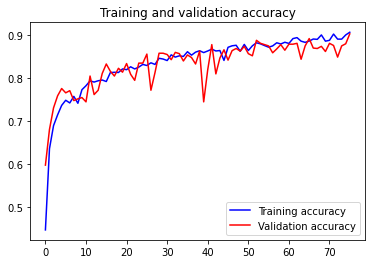

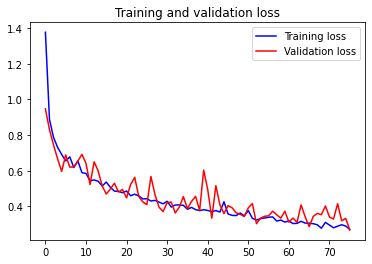

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()